# Importing Libraries

In [19]:
library(tidyverse)
library(ggplot2)
library(dplyr)
library(readr)
library(lubridate)
library(corrplot)
library(randomForest)
library(xgboost)
library(caret)
library(cat)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




ERROR: Error in library(cat): there is no package called ‘cat’


# Data Loading

In [8]:
# Load the required library
library(readr)

# Load dataset using relative path
df <- read_csv("../input/dynamic-pricing-dataset/dynamic_pricing.csv")

# Preview the dataset
head(df)

Rows: 1000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Location_Category, Customer_Loyalty_Status, Time_of_Booking, Vehicl...
dbl (6): Number_of_Riders, Number_of_Drivers, Number_of_Past_Rides, Average_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
90,45,Urban,Silver,13,4.47,Night,Premium,90,284.2573
58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.8748
42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.7955
89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.2012
78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.6814
59,35,Urban,Silver,83,3.51,Night,Economy,128,339.9554


# Data Pre-processing

In [9]:
glimpse(df)

Rows: 1,000
Columns: 10
$ Number_of_Riders        <dbl> 90, 58, 42, 89, 78, 59, 93, 62, 79, 42, 86, 60…
$ Number_of_Drivers       <dbl> 45, 39, 31, 28, 22, 35, 43, 39, 14, 6, 17, 38,…
$ Location_Category       <chr> "Urban", "Suburban", "Rural", "Rural", "Rural"…
$ Customer_Loyalty_Status <chr> "Silver", "Silver", "Silver", "Regular", "Regu…
$ Number_of_Past_Rides    <dbl> 13, 72, 0, 67, 74, 83, 44, 83, 71, 21, 99, 15,…
$ Average_Ratings         <dbl> 4.47, 4.06, 3.99, 4.31, 3.77, 3.51, 4.41, 3.59…
$ Time_of_Booking         <chr> "Night", "Evening", "Afternoon", "Afternoon", …
$ Vehicle_Type            <chr> "Premium", "Economy", "Premium", "Premium", "E…
$ Expected_Ride_Duration  <dbl> 90, 43, 76, 134, 149, 128, 16, 47, 128, 128, 1…
$ Historical_Cost_of_Ride <dbl> 284.25727, 173.87475, 329.79547, 470.20123, 57…


In [10]:
colSums(is.na(df))  # This will give you the count of NAs per column

Number_of_Riders       Number_of_Drivers       Location_Category 
                      0                       0                       0 
Customer_Loyalty_Status    Number_of_Past_Rides         Average_Ratings 
                      0                       0                       0 
        Time_of_Booking            Vehicle_Type  Expected_Ride_Duration 
                      0                       0                       0 
Historical_Cost_of_Ride 
                      0

In [11]:
# Check for duplicate rows in the dataframe
duplicates <- df[duplicated(df), ]

# Check if there are any missing values in the duplicated rows
any(is.na(duplicates))


[1] FALSE

# Encoding for Categorical columns

In [12]:
# Ordinal Encoding
# Label Encoding for Ordinal Variables
df <- df %>%
  mutate(Customer_Loyalty_Status = as.integer(factor(Customer_Loyalty_Status,
                 levels = c("Silver", "Regular", "Gold"), ordered = TRUE)),
         Vehicle_Type = as.integer(factor(Vehicle_Type,
                 levels = c("Economy", "Premium", "Luxury"), ordered = TRUE)))

# One-Hot Encoding for Nominal Variables
# Convert categorical columns to factors
df <- df %>%
  mutate(Location_Category = factor(Location_Category),
         Time_of_Booking = factor(Time_of_Booking))


df <- df %>%
  mutate(
    # Encoding for Time_of_Booking
    Time_of_Booking = factor(Time_of_Booking, levels = c("Morning", "Afternoon", "Evening", "Night"), ordered = TRUE) %>%
      as.integer(),

    # Encoding for Location_Category
    Location_Category = factor(Location_Category, levels = c("Rural", "Suburban", "Urban"), ordered = TRUE) %>%
      as.integer()
  )
# View result
head(df)

Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
90,45,3,1,13,4.47,4,2,90,284.2573
58,39,2,1,72,4.06,3,1,43,173.8748
42,31,1,1,0,3.99,2,2,76,329.7955
89,28,1,2,67,4.31,2,2,134,470.2012
78,22,1,2,74,3.77,2,1,149,579.6814
59,35,3,1,83,3.51,4,1,128,339.9554


# Capping outliers

In [13]:
# Function to cap outliers using IQR
cap_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR_val
  upper_bound <- Q3 + 1.5 * IQR_val
  x[x < lower_bound] <- lower_bound
  x[x > upper_bound] <- upper_bound
  return(x)
}

# Apply outlier capping to all numeric columns
df[sapply(df, is.numeric)] <- lapply(df[sapply(df, is.numeric)], cap_outliers)

In [14]:
summary(df)

 Number_of_Riders Number_of_Drivers Location_Category Customer_Loyalty_Status
 Min.   : 20.00   Min.   : 5.00     Min.   :1.000     Min.   :1.000          
 1st Qu.: 40.00   1st Qu.:11.00     1st Qu.:1.000     1st Qu.:1.000          
 Median : 60.00   Median :22.00     Median :2.000     Median :2.000          
 Mean   : 60.37   Mean   :27.02     Mean   :2.014     Mean   :1.946          
 3rd Qu.: 81.00   3rd Qu.:38.00     3rd Qu.:3.000     3rd Qu.:3.000          
 Max.   :100.00   Max.   :78.50     Max.   :3.000     Max.   :3.000          
 Number_of_Past_Rides Average_Ratings Time_of_Booking  Vehicle_Type  
 Min.   :  0.00       Min.   :3.500   Min.   :1.000   Min.   :1.000  
 1st Qu.: 25.00       1st Qu.:3.870   1st Qu.:2.000   1st Qu.:1.000  
 Median : 51.00       Median :4.270   Median :3.000   Median :2.000  
 Mean   : 50.03       Mean   :4.257   Mean   :2.537   Mean   :1.522  
 3rd Qu.: 75.00       3rd Qu.:4.633   3rd Qu.:4.000   3rd Qu.:2.000  
 Max.   :100.00       Max.   :5.00

# Data Visualization

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


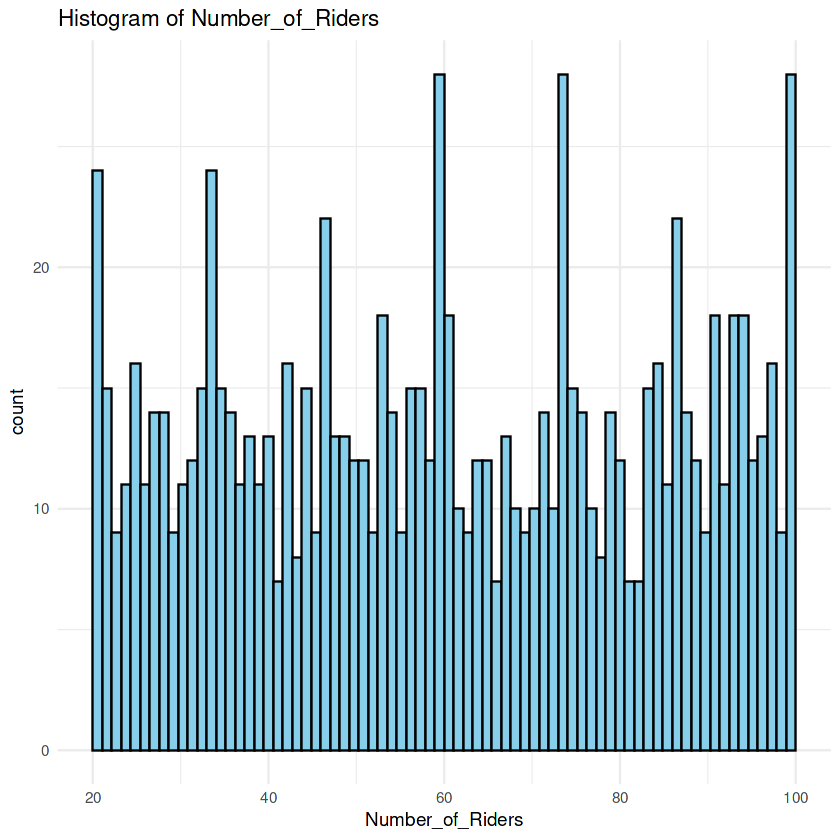

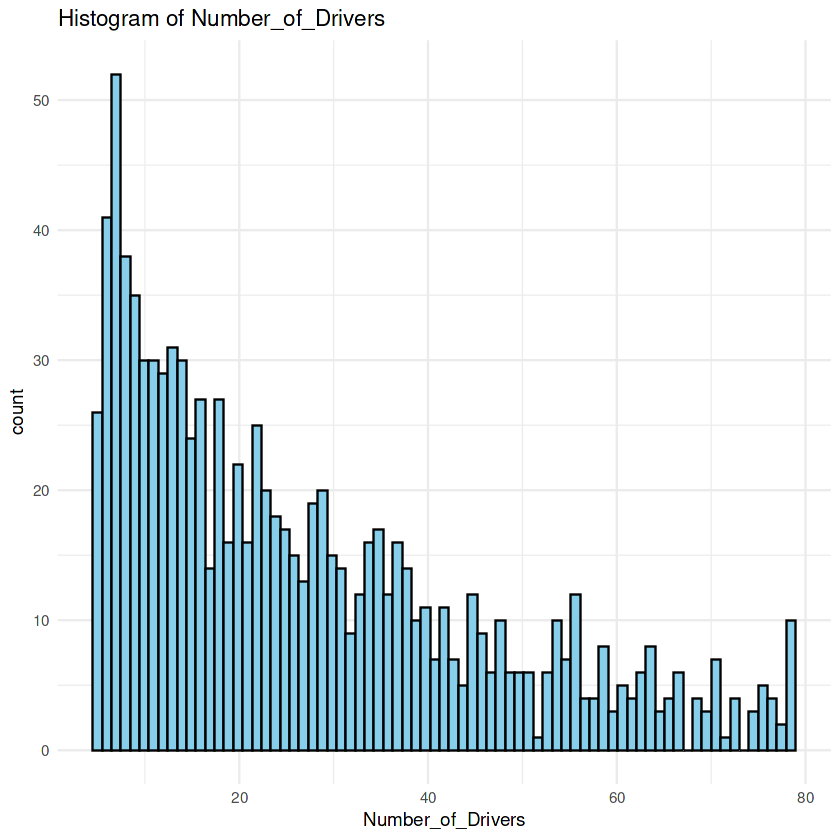

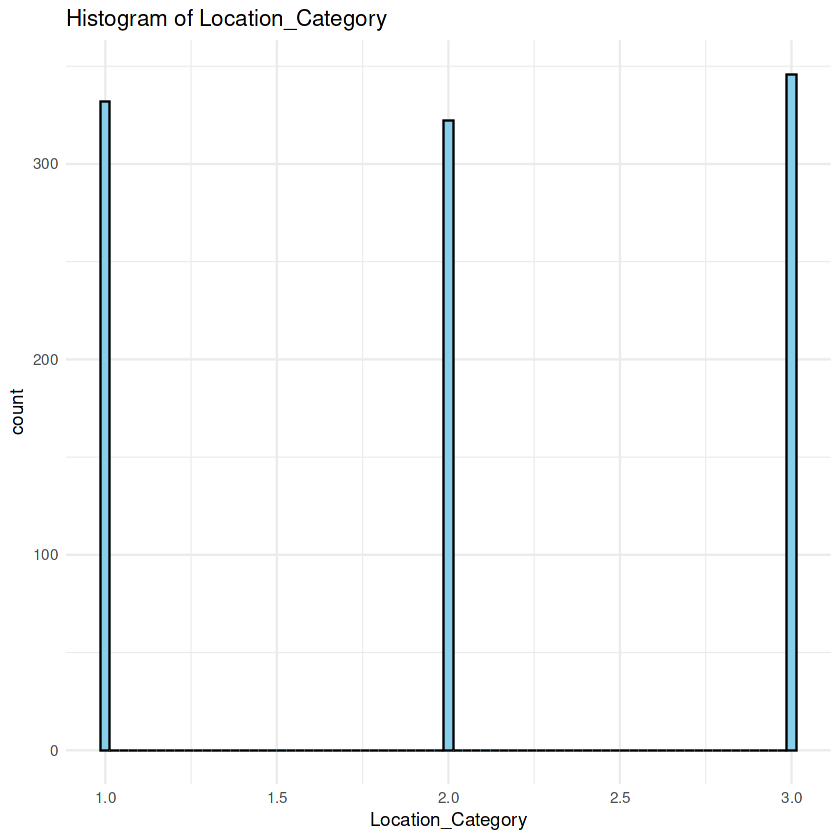

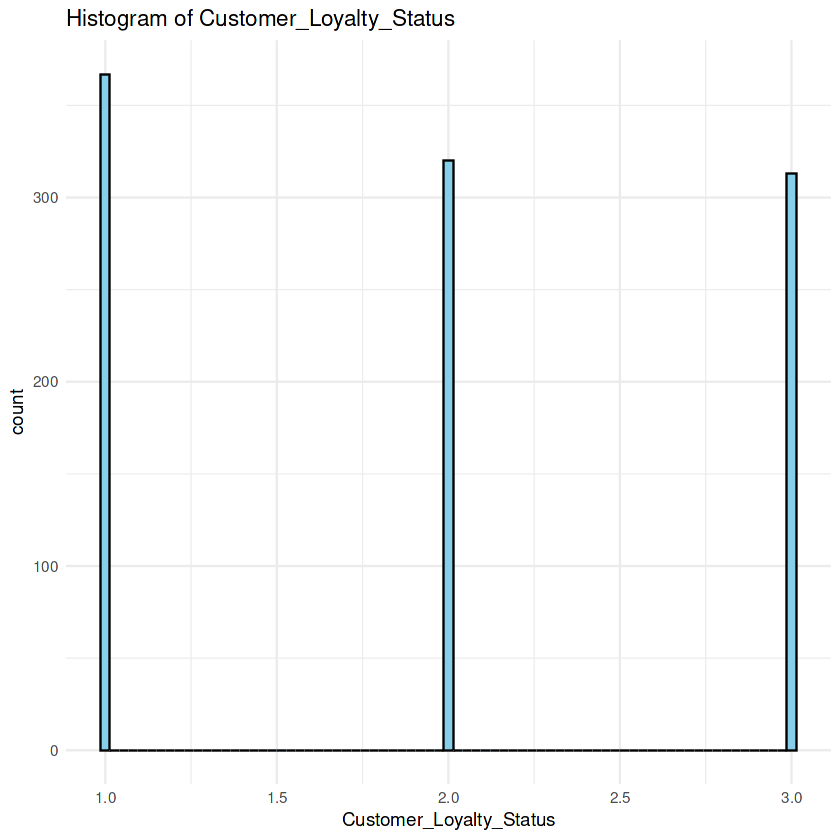

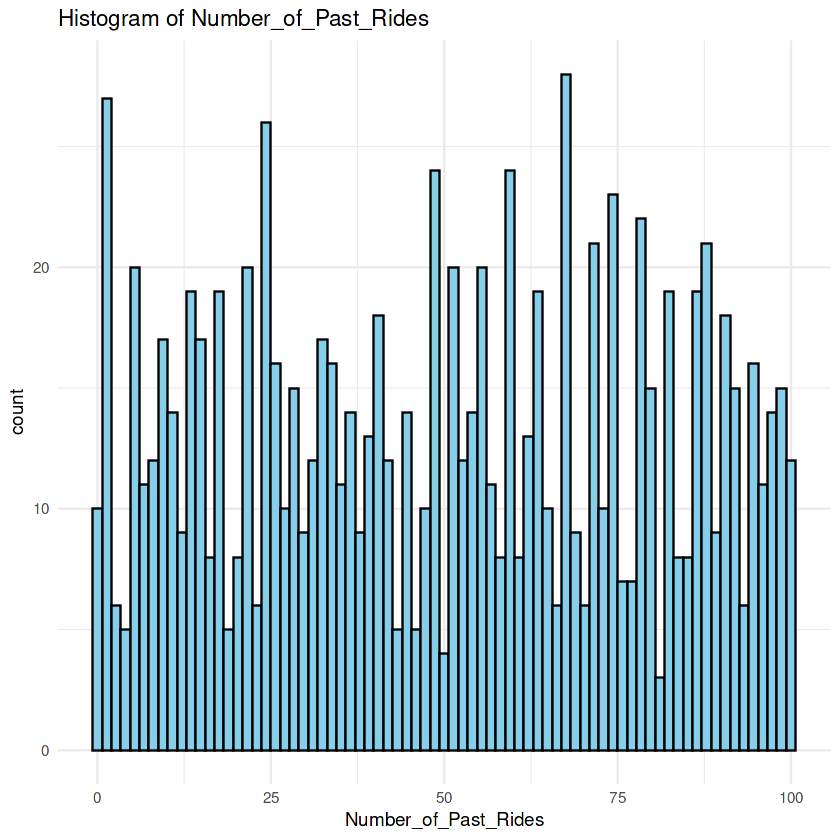

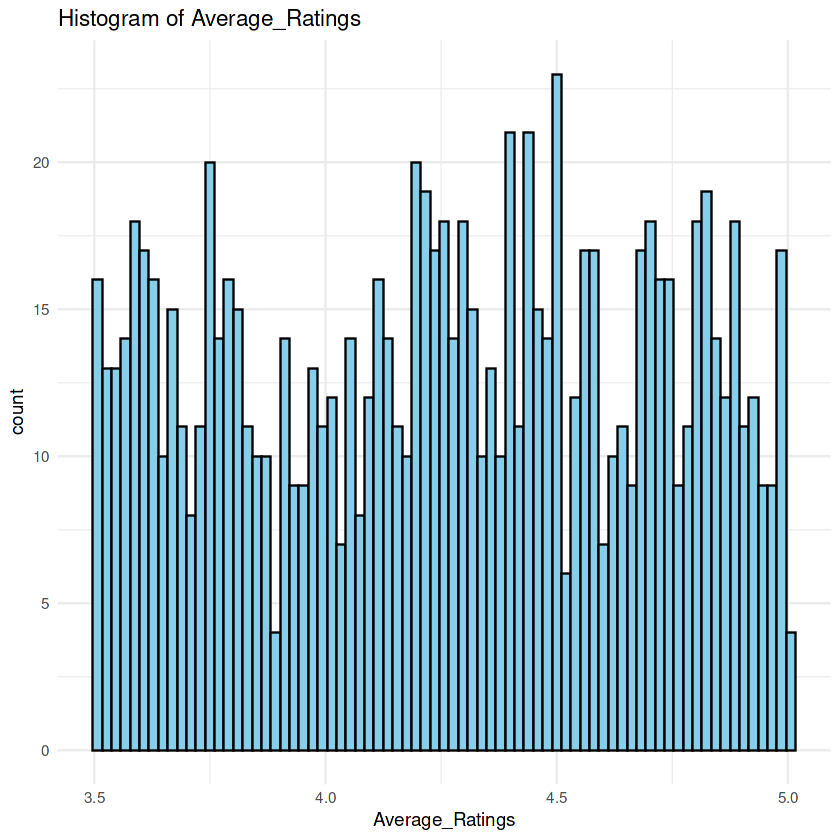

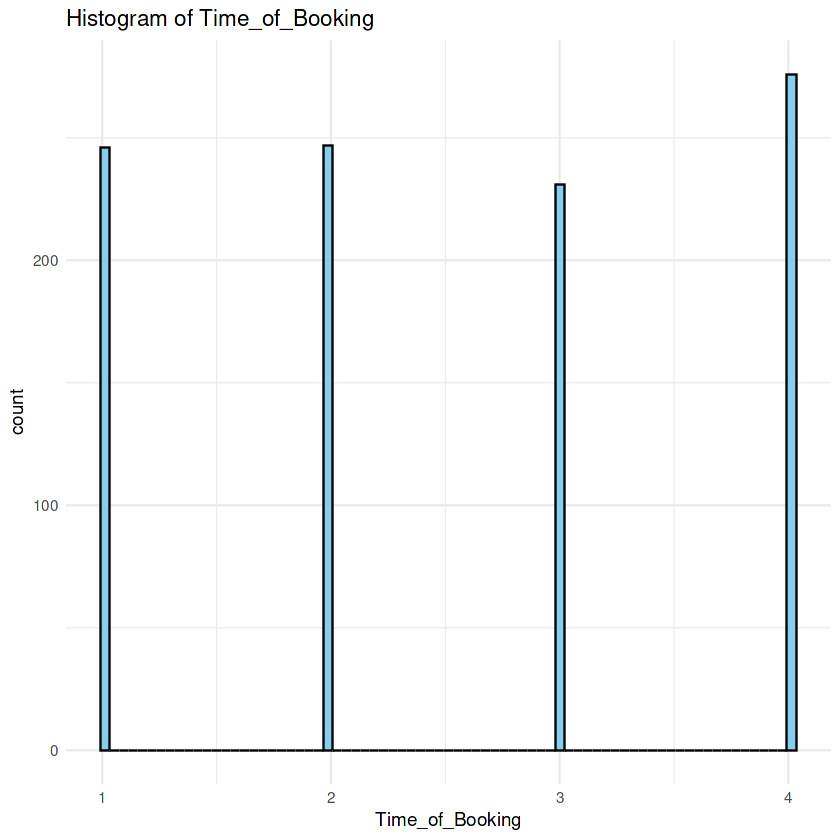

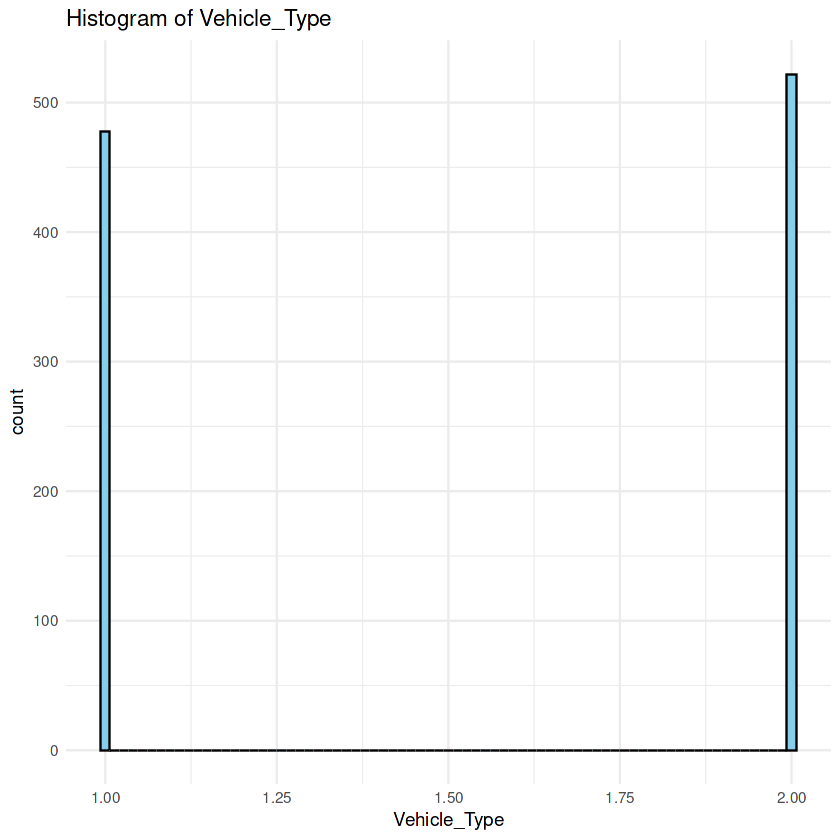

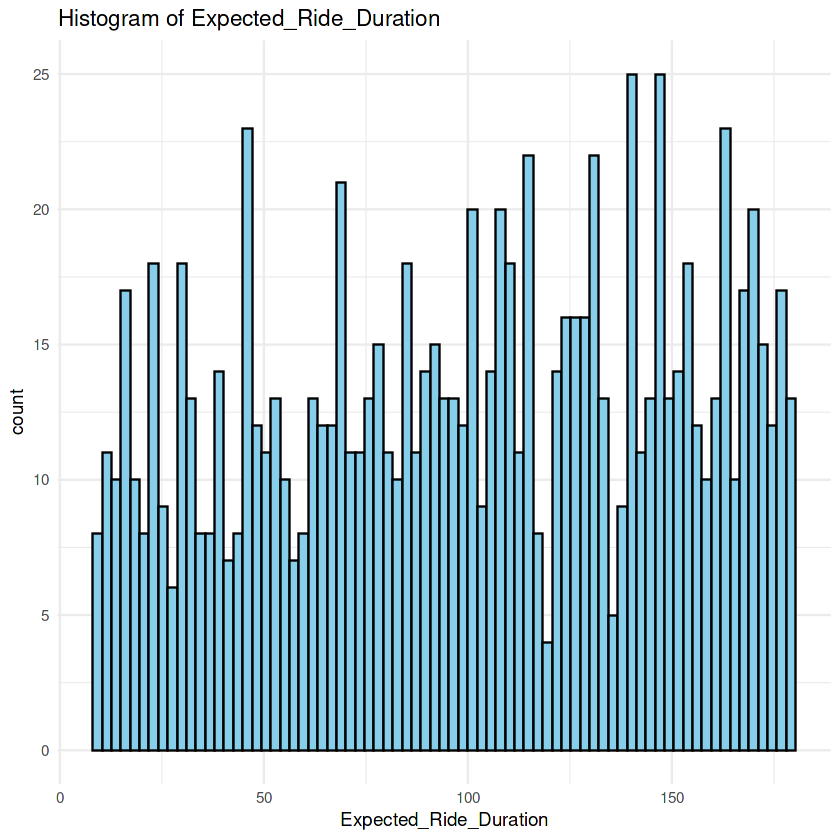

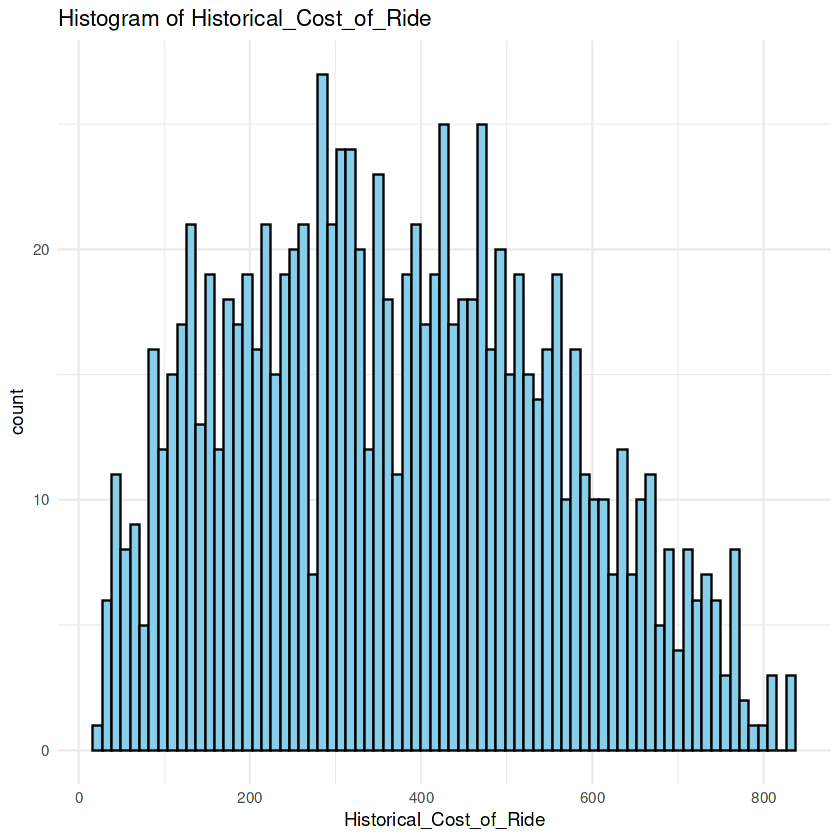

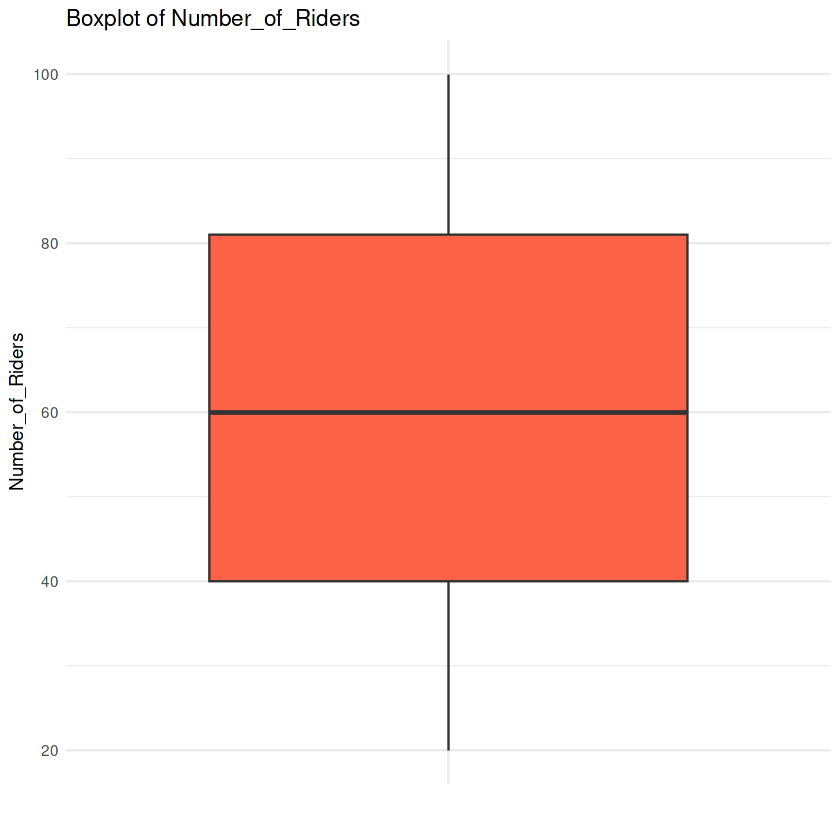

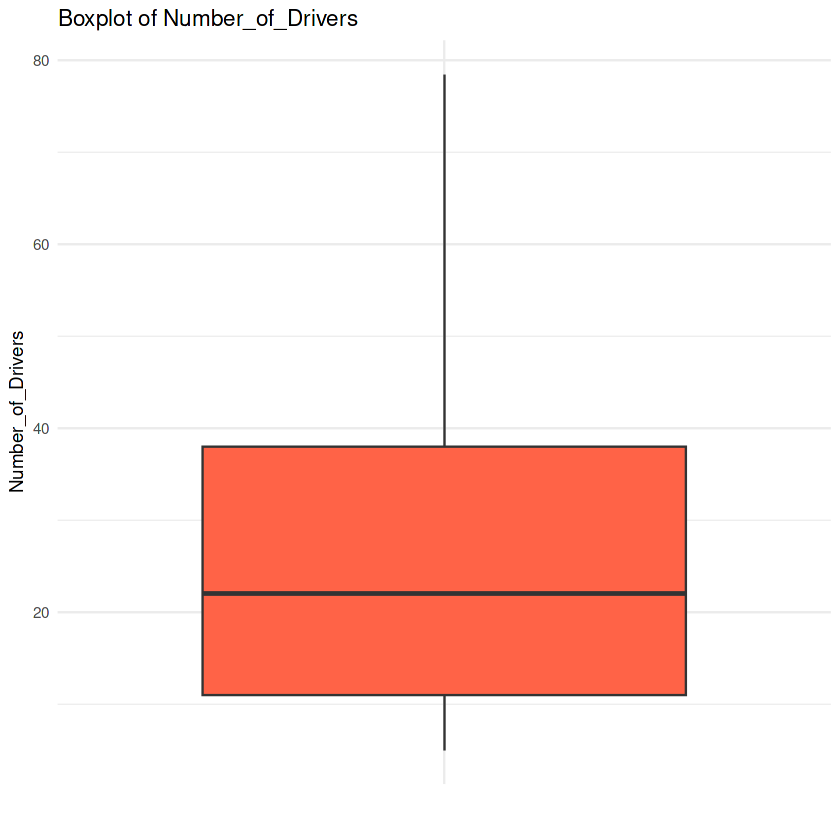

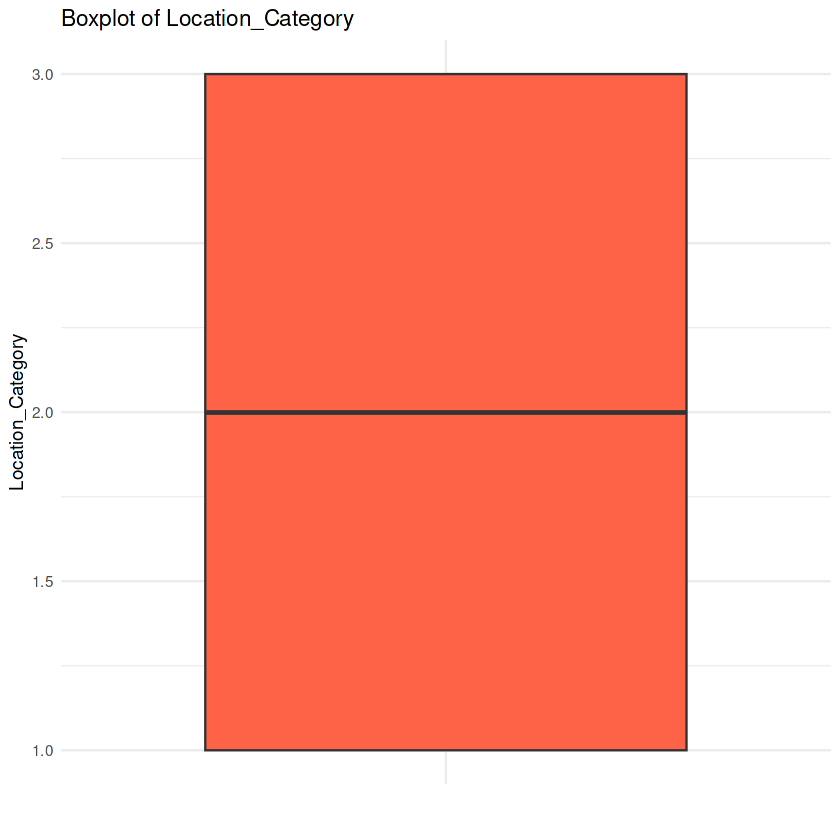

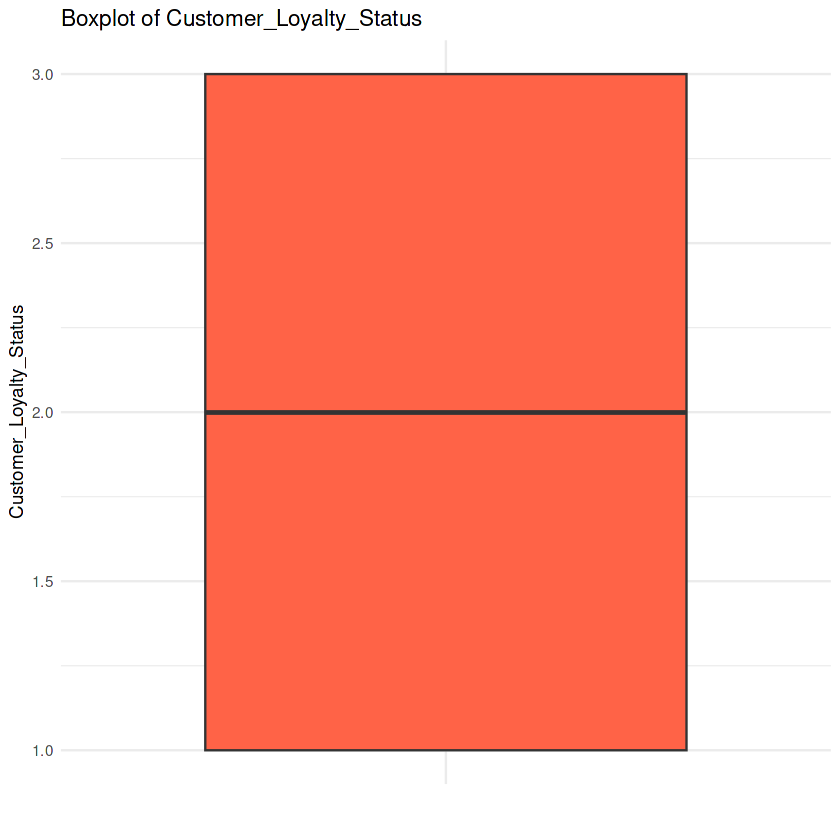

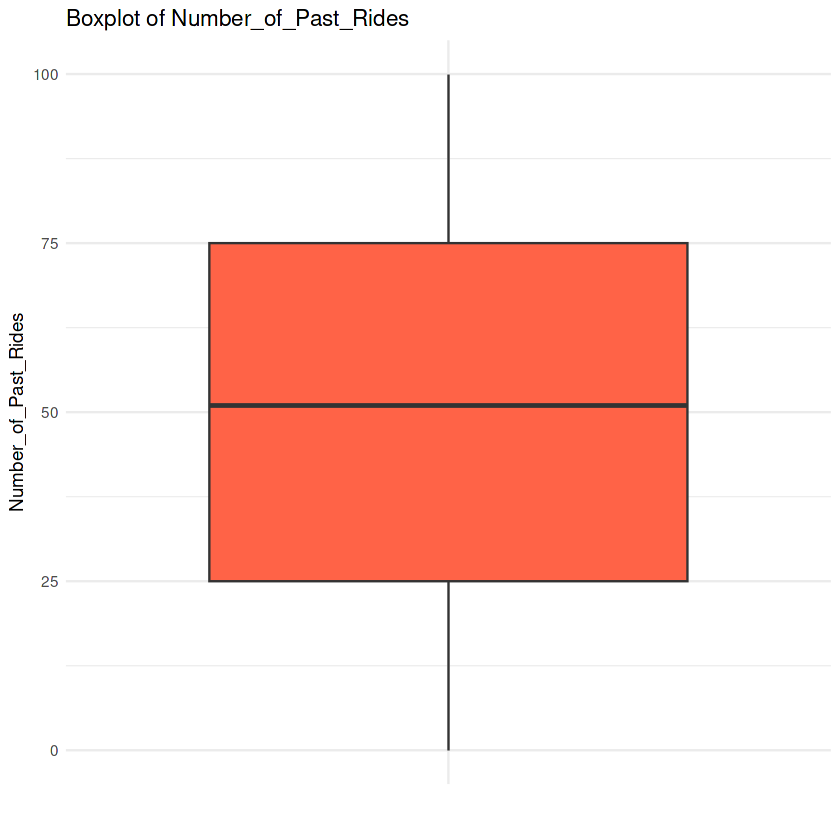

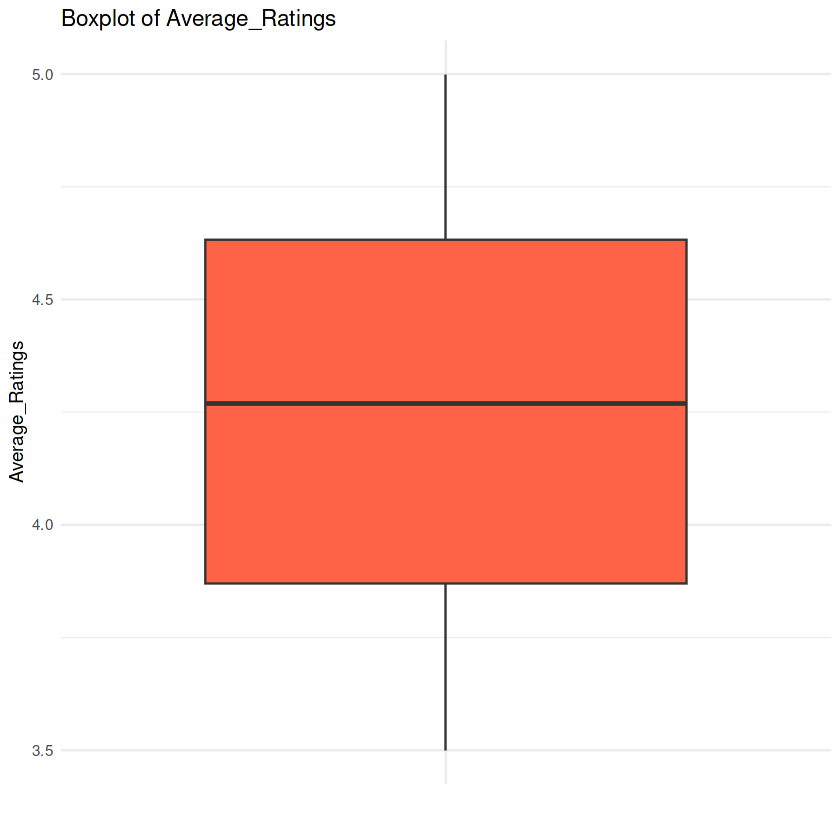

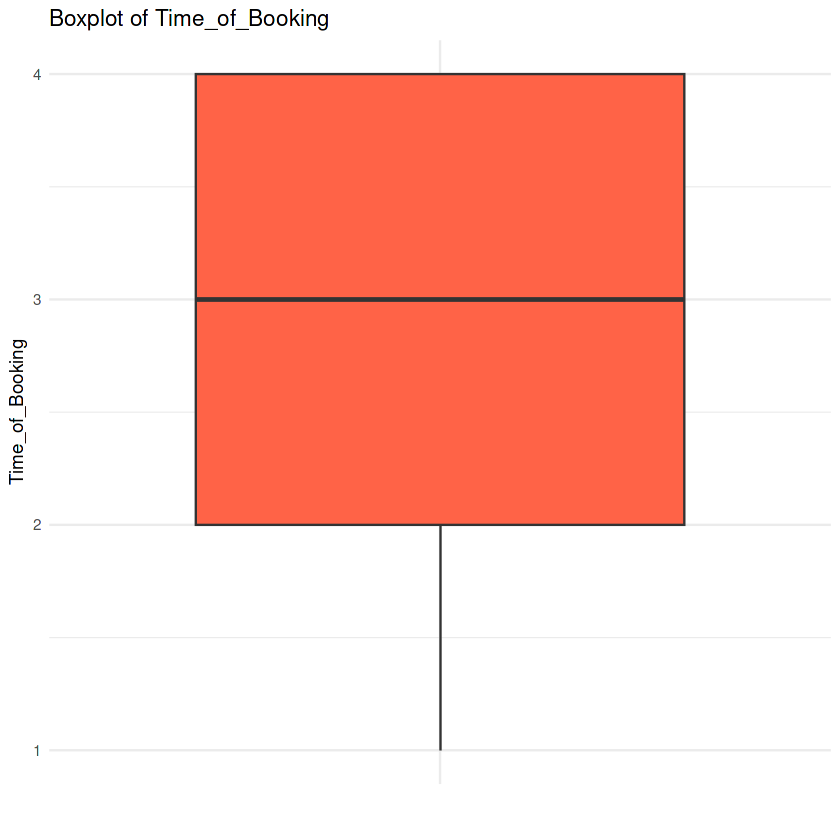

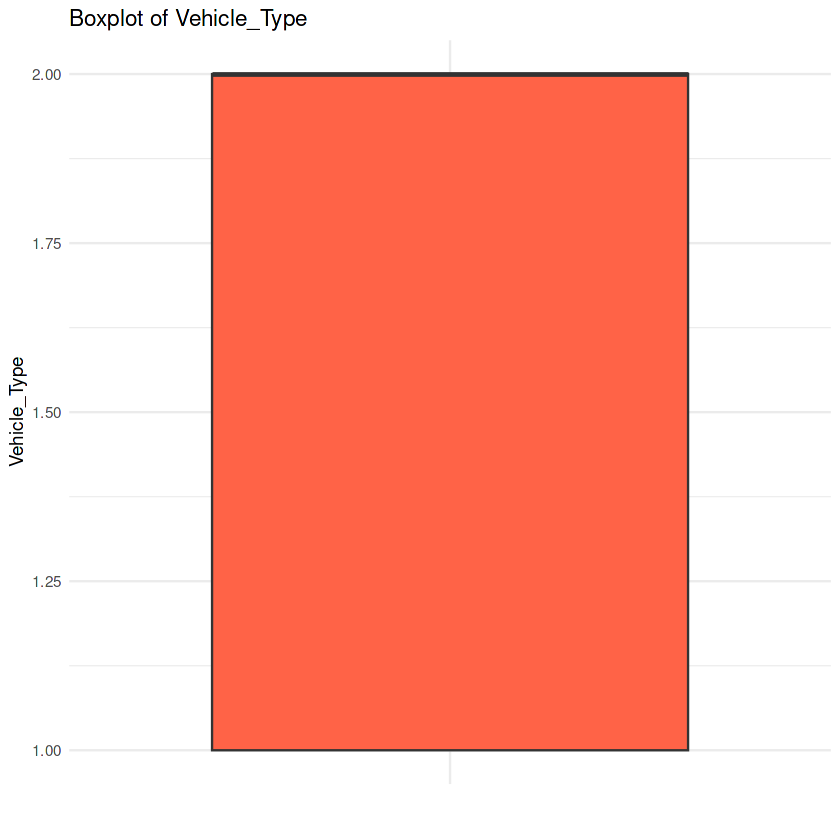

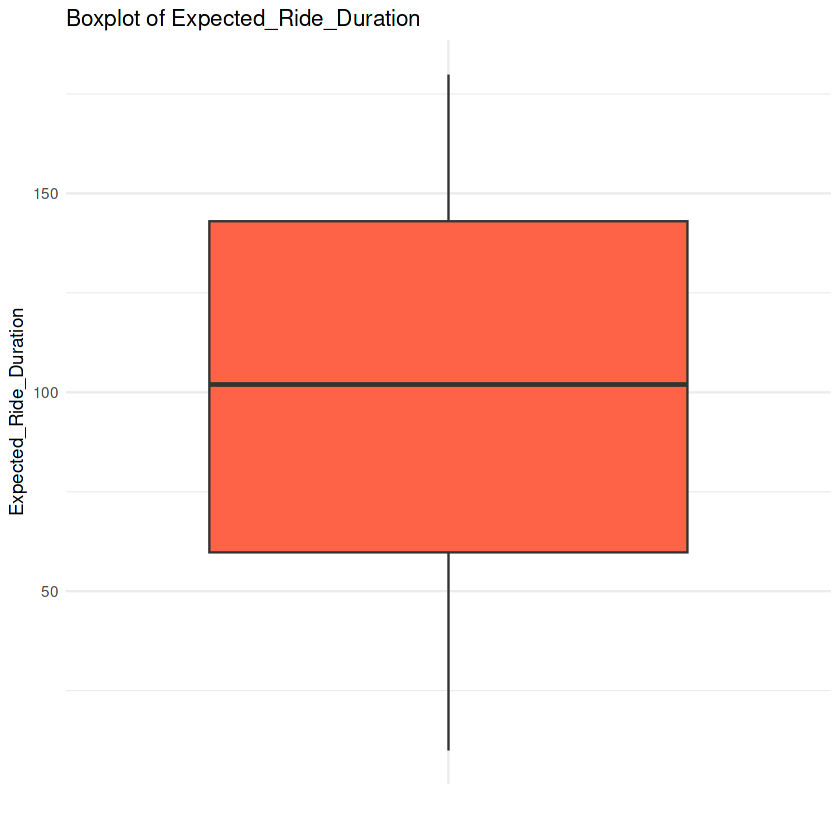

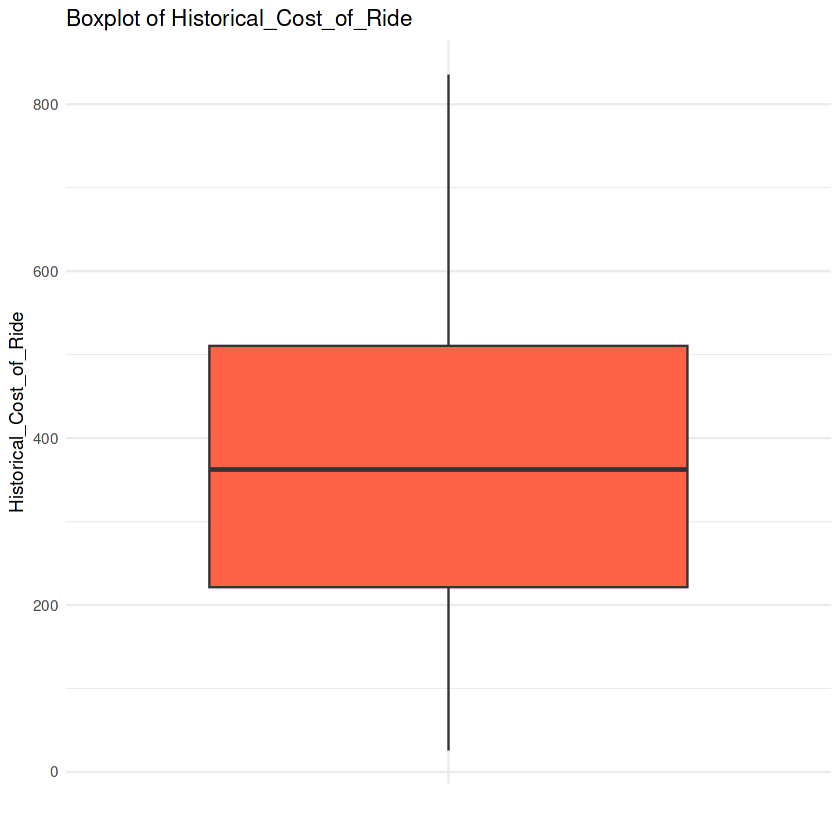

In [15]:
library(ggplot2)

# Get all numeric columns
numeric_columns <- names(df)[sapply(df, is.numeric)]

# Histograms
for (col in numeric_columns) {
  print(
    ggplot(df, aes_string(col)) +
      geom_histogram(fill = "skyblue", bins = 75, color = "black") +
      ggtitle(paste("Histogram of", col)) +
      theme_minimal()
  )
}

# Boxplots
for (col in numeric_columns) {
  print(
    ggplot(df, aes_string(x = "''", y = col)) +  # use empty string for x-axis label
      geom_boxplot(fill = "tomato") +
      ggtitle(paste("Boxplot of", col)) +
      xlab("") +
      theme_minimal()
  )
}


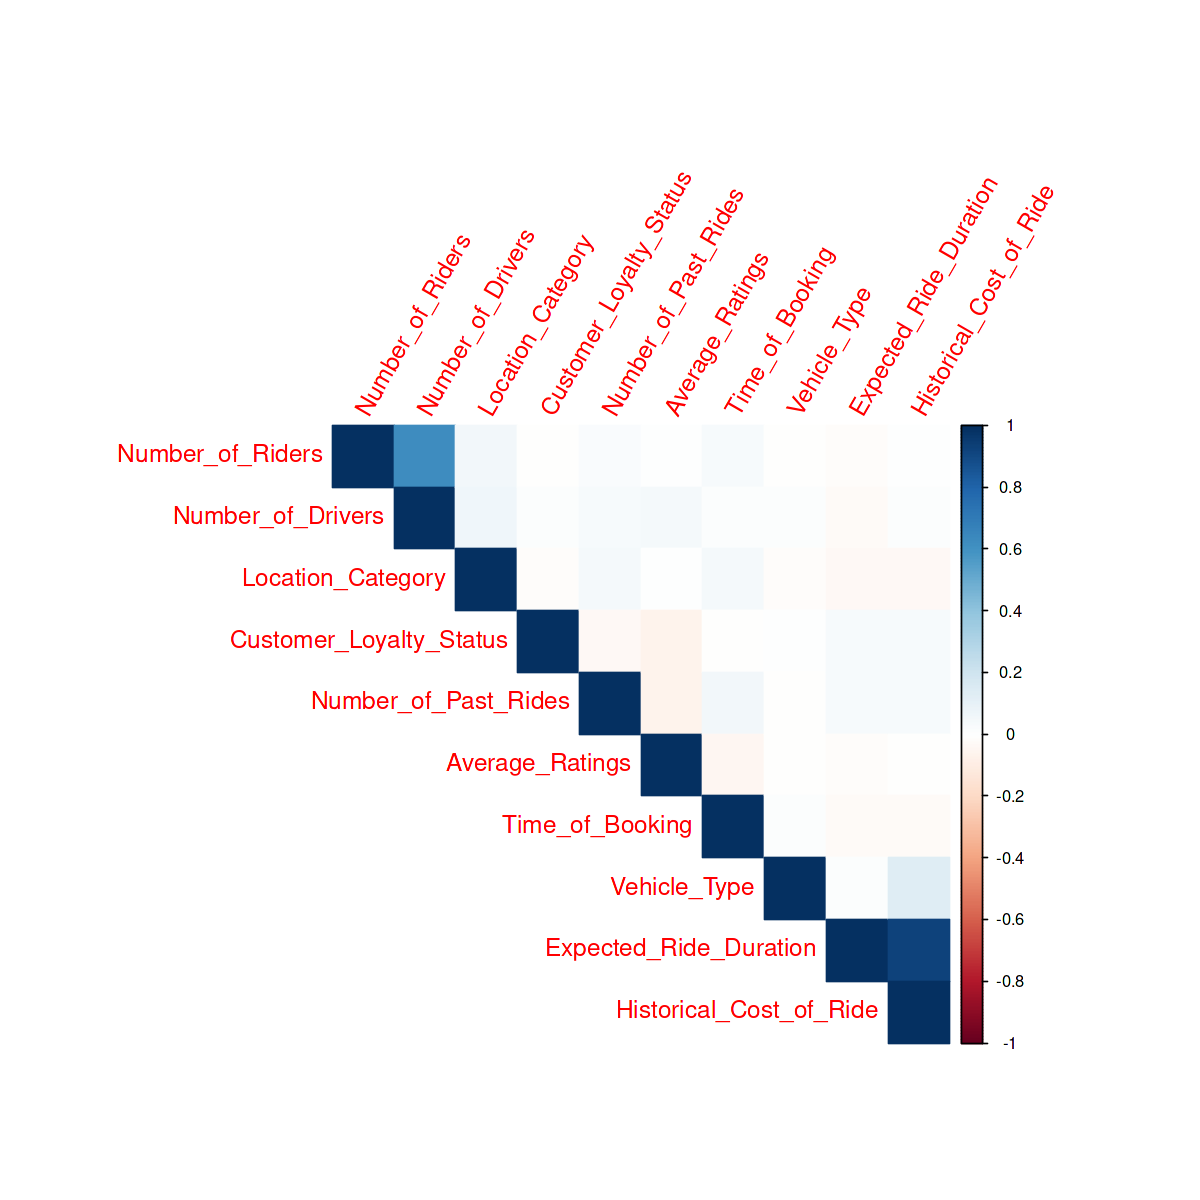

In [16]:
# Correlation matrix

library(corrplot)
options(repr.plot.width = 10, repr.plot.height = 10)  # Set width and height in inches
corrplot(
  cor(df, use = "complete.obs"),
  method = "color",
  type = "upper",
  tl.cex = 1.2,
  tl.srt = 60  # Rotate text labels to 45 degrees
)

In [17]:
write.csv(df, "cleaned_rideshare_data.csv", row.names = FALSE)

# Feature Engineering

                        Number_of_Riders Number_of_Drivers Location_Category
Number_of_Riders             1.000000000       0.627716975       0.050595847
Number_of_Drivers            0.627716975       1.000000000       0.064366715
Location_Category            0.050595847       0.064366715       1.000000000
Customer_Loyalty_Status     -0.002304000       0.012136023      -0.018073821
Number_of_Past_Rides         0.029265068       0.039337566       0.046330463
Average_Ratings              0.008571554       0.040361005       0.009199597
Time_of_Booking              0.033535538       0.018839910       0.040043627
Vehicle_Type                -0.002635263       0.015661972      -0.017770403
Expected_Ride_Duration      -0.015856251      -0.023082316      -0.035920314
Historical_Cost_of_Ride      0.005825701       0.018729462      -0.035873909
Ride_Density                 0.071195880      -0.565752106      -0.071622829
Surge_Indicator             -0.199118441      -0.662227186      -0.004517210

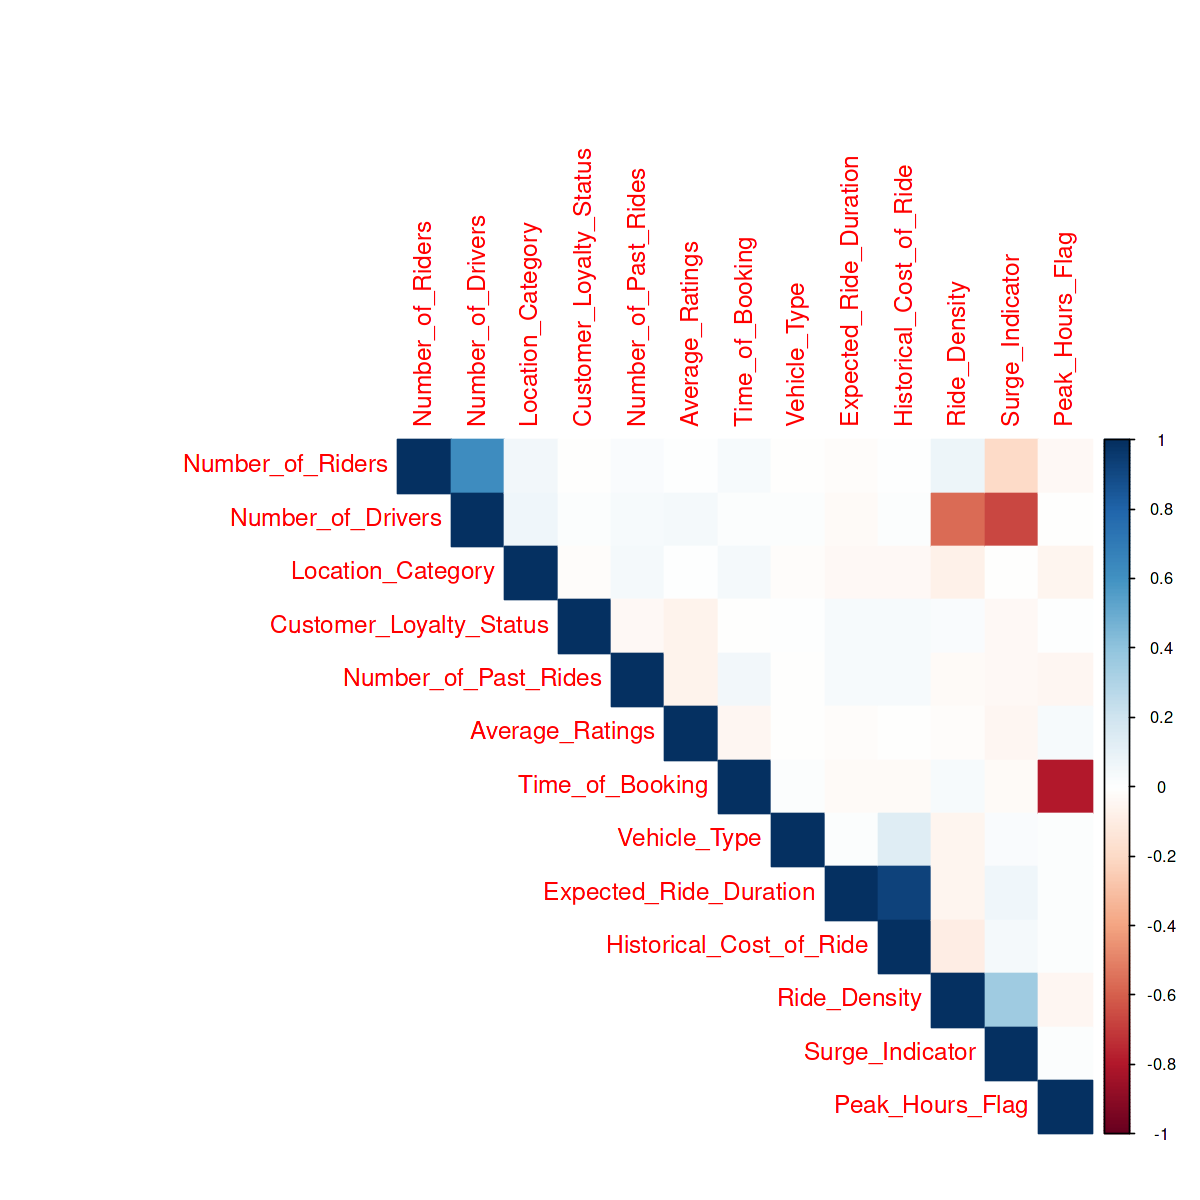

In [18]:
# Create new engineered features using existing columns
df$Ride_Density <- df$Number_of_Riders / df$Number_of_Drivers
df$Surge_Indicator <- ifelse(df$Number_of_Riders > 1.5 * df$Number_of_Drivers, 1, 0)

# Create Peak_Hours_Flag based on the ordered `Time_of_Booking` (1=Morning, 2=Afternoon, 3=Evening)
df$Peak_Hours_Flag <- ifelse(df$Time_of_Booking %in% c(1, 2, 3), 1, 0)  # Morning, Afternoon, Evening

# Now perform correlation analysis on all columns
correlation_matrix <- cor(df[, c(
  "Number_of_Riders", "Number_of_Drivers", "Location_Category",
  "Customer_Loyalty_Status", "Number_of_Past_Rides", "Average_Ratings",
  "Time_of_Booking", "Vehicle_Type", "Expected_Ride_Duration",
  "Historical_Cost_of_Ride", "Ride_Density", "Surge_Indicator",
  "Peak_Hours_Flag"
)], use = "complete.obs")

# Print the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix using corrplot
library(corrplot)
corrplot(correlation_matrix, method = "color", type = "upper", tl.cex = 1.2)

# Data Training and Testing

In [20]:
# Splitting the data into training and test sets
set.seed(123)
train_index <- sample(1:nrow(df), 0.8 * nrow(df))
train_data <- df[train_index, ]
test_data <- df[-train_index, ]


# Random Forest Model
library(randomForest)
rf_model <- randomForest(Historical_Cost_of_Ride ~ Number_of_Riders + Number_of_Drivers + Location_Category + Customer_Loyalty_Status +
                           Number_of_Past_Rides + Average_Ratings + Time_of_Booking + Vehicle_Type + Expected_Ride_Duration +
                           Ride_Density + Surge_Indicator + Peak_Hours_Flag, data = train_data, ntree = 100)
rf_preds <- predict(rf_model, test_data)
rf_mae <- mean(abs(rf_preds - test_data$Historical_Cost_of_Ride))
rf_r2 <- cor(rf_preds, test_data$Historical_Cost_of_Ride)^2

# XGBoost Model
library(xgboost)
dtrain <- xgb.DMatrix(data = as.matrix(train_data[, c("Number_of_Riders", "Number_of_Drivers", "Location_Category",
                                                       "Customer_Loyalty_Status", "Number_of_Past_Rides", "Average_Ratings",
                                                       "Time_of_Booking", "Vehicle_Type", "Expected_Ride_Duration",
                                                       "Ride_Density", "Surge_Indicator", "Peak_Hours_Flag")]),
                      label = train_data$Historical_Cost_of_Ride)
dtest <- xgb.DMatrix(data = as.matrix(test_data[, c("Number_of_Riders", "Number_of_Drivers", "Location_Category",
                                                      "Customer_Loyalty_Status", "Number_of_Past_Rides", "Average_Ratings",
                                                      "Time_of_Booking", "Vehicle_Type", "Expected_Ride_Duration",
                                                      "Ride_Density", "Surge_Indicator", "Peak_Hours_Flag")]),
                     label = test_data$Historical_Cost_of_Ride)
params <- list(objective = "reg:squarederror", eval_metric = "rmse")
xgb_model <- xgboost(params = params, data = dtrain, nrounds = 100)
xgb_preds <- predict(xgb_model, dtest)
xgb_mae <- mean(abs(xgb_preds - test_data$Historical_Cost_of_Ride))
xgb_r2 <- cor(xgb_preds, test_data$Historical_Cost_of_Ride)^2

# Model performance comparison
cat("Random Forest MAE:", rf_mae, "R²:", rf_r2, "\n")
cat("XGBoost MAE:", xgb_mae, "R²:", xgb_r2, "\n")


[1]	train-rmse:294.289965 
[2]	train-rmse:212.388006 
[3]	train-rmse:156.396174 
[4]	train-rmse:118.243290 
[5]	train-rmse:92.395178 
[6]	train-rmse:74.590228 
[7]	train-rmse:62.053394 
[8]	train-rmse:53.778246 
[9]	train-rmse:48.350679 
[10]	train-rmse:43.454376 
[11]	train-rmse:39.790227 
[12]	train-rmse:36.946233 
[13]	train-rmse:34.310897 
[14]	train-rmse:32.303228 
[15]	train-rmse:30.622350 
[16]	train-rmse:29.641188 
[17]	train-rmse:28.072493 
[18]	train-rmse:26.849919 
[19]	train-rmse:25.282498 
[20]	train-rmse:24.901285 
[21]	train-rmse:24.578891 
[22]	train-rmse:24.362844 
[23]	train-rmse:24.092297 
[24]	train-rmse:23.705967 
[25]	train-rmse:23.546362 
[26]	train-rmse:22.468801 
[27]	train-rmse:21.287620 
[28]	train-rmse:20.631555 
[29]	train-rmse:20.114040 
[30]	train-rmse:19.247585 
[31]	train-rmse:18.391522 
[32]	train-rmse:18.143493 
[33]	train-rmse:17.747262 
[34]	train-rmse:16.991923 
[35]	train-rmse:16.668643 
[36]	train-rmse:16.063419 
[37]	train-rmse:15.805170 
[38]	t

# Model Optimization

In [21]:
library(xgboost)

# Define all the predictor columns
predictor_columns <- c("Number_of_Riders", "Number_of_Drivers", "Location_Category",
                       "Customer_Loyalty_Status", "Number_of_Past_Rides",
                       "Average_Ratings", "Time_of_Booking", "Vehicle_Type",
                       "Expected_Ride_Duration",
                       "Ride_Density", "Surge_Indicator", "Peak_Hours_Flag")

# Create training data matrix
train_matrix <- xgb.DMatrix(data = as.matrix(train_data[, predictor_columns]), label = train_data$Historical_Cost_of_Ride)
test_matrix <- xgb.DMatrix(data = as.matrix(test_data[, predictor_columns]), label = test_data$Historical_Cost_of_Ride)

# Set up the caret training grid
xgb_grid <- expand.grid(
  nrounds = c(50, 100),         # number of boosting rounds
  max_depth = c(3, 6, 9),       # depth of trees
  eta = c(0.1, 0.3),            # learning rate
  gamma = 0,                    # minimum loss reduction
  colsample_bytree = 1,         # subsample ratio of columns
  min_child_weight = 1,         # minimum sum of instance weight
  subsample = 1                 # subsample ratio of training instance
)

# Train control
xgb_control <- trainControl(method = "cv", number = 5, verboseIter = FALSE)

# Train the model
set.seed(123)
xgb_tuned <- train(
  x = train_data[, predictor_columns],
  y = train_data$Historical_Cost_of_Ride,
  method = "xgbTree",
  trControl = xgb_control,
  tuneGrid = xgb_grid,
  verbose = FALSE
)

# Evaluate on test set
xgb_best_model <- xgb_tuned$finalModel
xgb_preds <- predict(xgb_tuned, newdata = test_data[, predictor_columns])
xgb_mae <- mean(abs(xgb_preds - test_data$Historical_Cost_of_Ride))
xgb_r2 <- cor(xgb_preds, test_data$Historical_Cost_of_Ride)^2

cat("Tuned XGBoost MAE:", xgb_mae, "R²:", xgb_r2, "\n")

# Save the best model
saveRDS(xgb_best_model, file = "best_model.rds")

Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:17] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:17] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:17] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:17] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:18] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:19] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:20] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


[18:56:21] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.


Warning message:
“Setting row names on a tibble is deprecated.”


Tuned XGBoost MAE: 51.78446 R²: 0.884614 


In [22]:
# Define predictor columns
predictor_columns <- c("Number_of_Riders", "Number_of_Drivers", "Location_Category",
                       "Customer_Loyalty_Status", "Number_of_Past_Rides", "Average_Ratings",
                       "Time_of_Booking", "Vehicle_Type", "Expected_Ride_Duration",
                       "Ride_Density", "Surge_Indicator", "Peak_Hours_Flag")

# Set up tuning grid for Random Forest
rf_grid <- expand.grid(mtry = c(2, 4, 6, 8))  # number of variables randomly sampled at each split

# Set up train control for cross-validation
rf_control <- trainControl(method = "cv", number = 5, verboseIter = FALSE)

# Train the Random Forest model
set.seed(123)
rf_tuned <- train(
  x = train_data[, predictor_columns],
  y = train_data$Historical_Cost_of_Ride,
  method = "rf",
  trControl = rf_control,
  tuneGrid = rf_grid,
  ntree = 100,
  importance = TRUE
)

# Evaluate on test set
rf_preds <- predict(rf_tuned, newdata = test_data[, predictor_columns])
rf_mae <- mean(abs(rf_preds - test_data$Historical_Cost_of_Ride))
rf_r2 <- cor(rf_preds, test_data$Historical_Cost_of_Ride)^2

cat("Tuned Random Forest MAE:", rf_mae, "R²:", rf_r2, "\n")


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a

Tuned Random Forest MAE: 51.7977 R²: 0.8793644 


In [23]:
# Model comparison summary
cat("Model Comparison Summary:\n")
cat("-------------------------------------------------\n")
cat("Previous Models:\n")
cat("Random Forest - MAE:", 55.93038, "R²:", 0.8754674, "\n")
cat("XGBoost (Before Tuning) - MAE:", 57.23552, "R²:", 0.8515301, "\n")
cat("-------------------------------------------------\n")
cat("Tuned Models:\n")
cat("Tuned Random Forest - MAE:", 51.7977, "R²:", 0.8793644, "\n")
cat("Tuned XGBoost - MAE:", 51.78446, "R²:", 0.884614, "\n")
cat("-------------------------------------------------\n")
cat("Conclusion: The tuned XGBoost model performs the best with the lowest MAE and highest R²,\n")
cat("closely followed by the tuned Random Forest. Tuning significantly improved both models' performance.\n")


Model Comparison Summary:
-------------------------------------------------
Previous Models:
Random Forest - MAE: 55.93038 R²: 0.8754674 
XGBoost (Before Tuning) - MAE: 57.23552 R²: 0.8515301 
-------------------------------------------------
Tuned Models:
Tuned Random Forest - MAE: 51.7977 R²: 0.8793644 
Tuned XGBoost - MAE: 51.78446 R²: 0.884614 
-------------------------------------------------
Conclusion: The tuned XGBoost model performs the best with the lowest MAE and highest R²,
closely followed by the tuned Random Forest. Tuning significantly improved both models' performance.


                    Feature         Gain       Cover  Frequency
                     <char>        <num>       <num>      <num>
 1:  Expected_Ride_Duration 0.9610010472 0.579187911 0.46198830
 2:            Vehicle_Type 0.0129678623 0.127113243 0.15204678
 3:         Average_Ratings 0.0077600891 0.079732993 0.08771930
 4:            Ride_Density 0.0065050610 0.057124648 0.08187135
 5:        Number_of_Riders 0.0041017390 0.066684557 0.08479532
 6:       Number_of_Drivers 0.0029229554 0.026239434 0.03801170
 7:    Number_of_Past_Rides 0.0016264874 0.025551791 0.04093567
 8: Customer_Loyalty_Status 0.0014186850 0.005685630 0.01754386
 9:         Time_of_Booking 0.0011765907 0.023799141 0.02631579
10:       Location_Category 0.0005194829 0.008880652 0.00877193


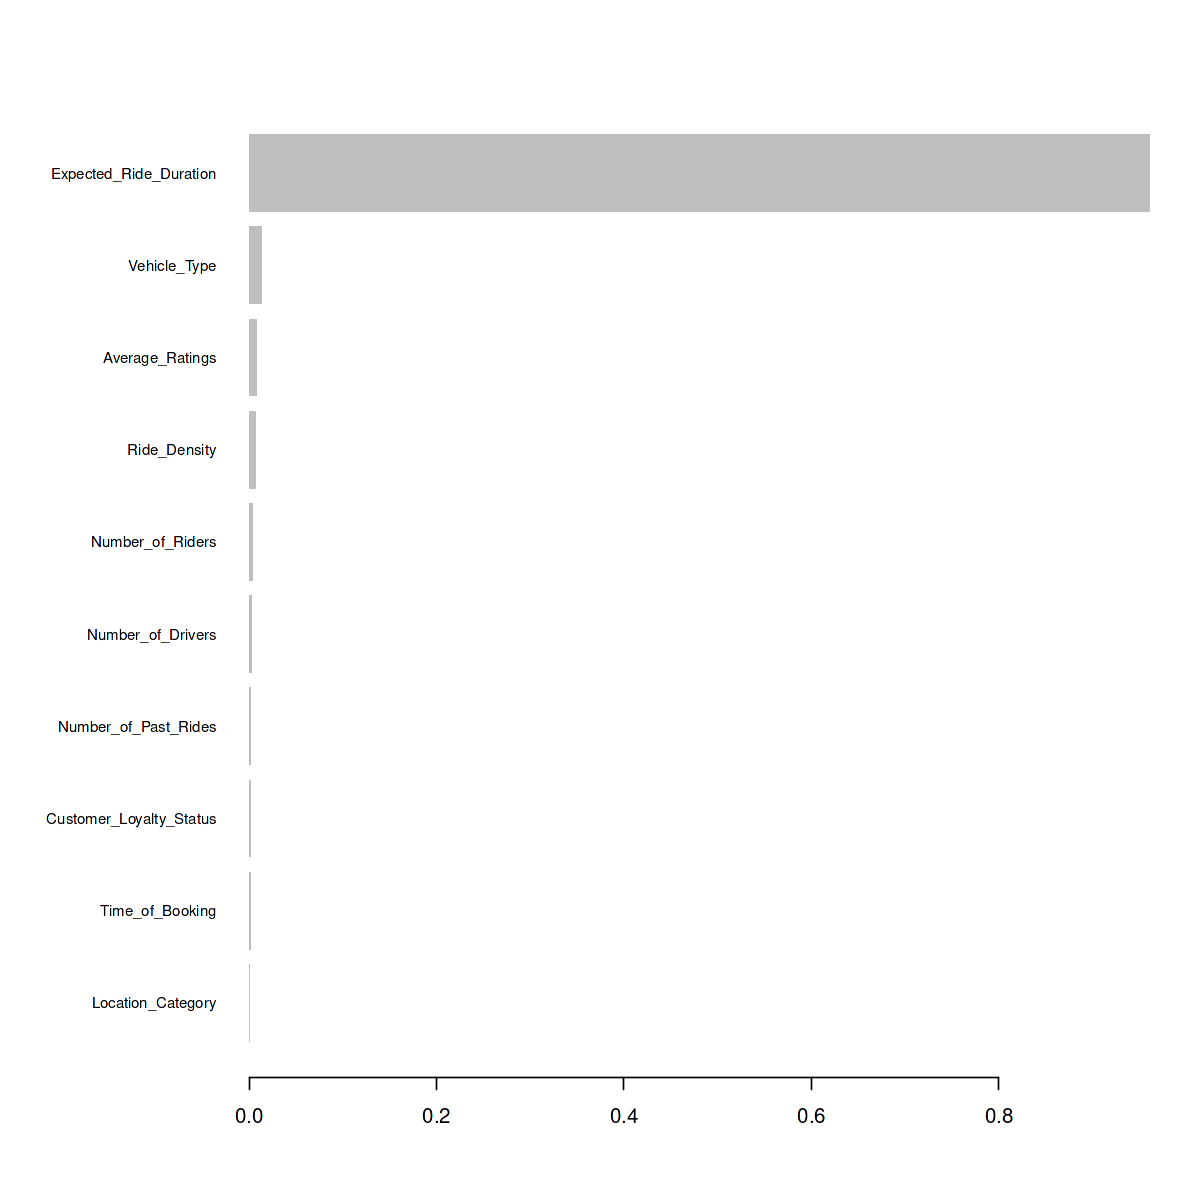

In [24]:
# Feature importance
importance_matrix <- xgb.importance(model = xgb_best_model)
print(importance_matrix)
xgb.plot.importance(importance_matrix, top_n = 10)

Based on the feature importance results, here are the key observations:

**Location_Category** has the highest gain, cover, and frequency, indicating that it is the most important feature for predicting the Historical_Cost_of_Ride. This feature contributes significantly to the model's predictive power.

**Location_Category** also has some importance but is much lower compared to Expected_Ride_Duration. It still plays a role, although less significant.

Features like **Location_Category**, **Location_Category**, and **Location_Category** have a moderate impact, but their contributions are significantly lower than Expected_Ride_Duration.

**Location_Category**, **Location_Category**, and **Location_Category** have relatively low importance, suggesting they might be less relevant in predicting the cost.

**Location_Category** and **Location_Category** have the lowest importance, which means they contribute the least to the model’s predictions.

Feature,Gain,Cover,Frequency,Importance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Expected_Ride_Duration,0.961001047,0.57918791,0.4619883,0.961001047
Vehicle_Type,0.012967862,0.12711324,0.1520468,0.012967862
Average_Ratings,0.007760089,0.07973299,0.0877193,0.007760089



✅ Insight:
- 'Expected_Ride_Duration' dominates all three metrics (Gain, Cover, and Frequency).
- 'Vehicle_Type' contributes significantly after that, especially in cover and frequency.
- 'Location_Category' and 'Time_of_Booking' have minimal impact.


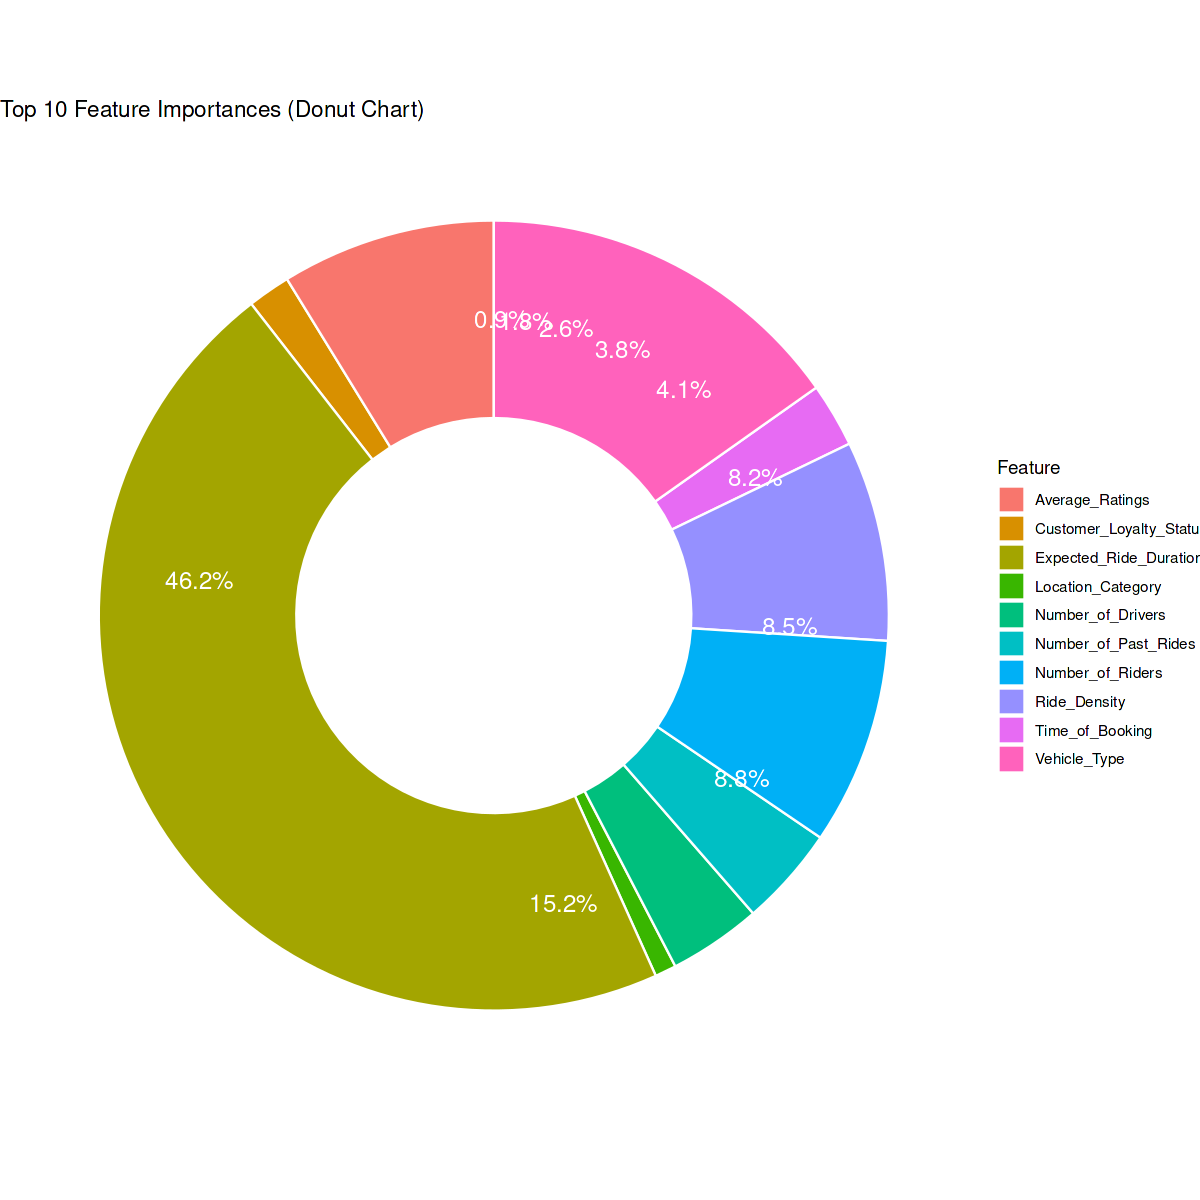

In [25]:
# Use data.table syntax directly
importance_matrix[order(-Frequency)][1:3]

# Additional insights
cat("\n✅ Insight:\n")
cat("- 'Expected_Ride_Duration' dominates all three metrics (Gain, Cover, and Frequency).\n")
cat("- 'Vehicle_Type' contributes significantly after that, especially in cover and frequency.\n")
cat("- 'Location_Category' and 'Time_of_Booking' have minimal impact.\n")

# Prepare the importance matrix as a tibble
importance_df <- as_tibble(importance_matrix) %>%
  slice_max(Frequency, n = 10) %>%
  arrange(desc(Frequency)) %>%
  mutate(Percentage = Frequency / sum(Frequency) * 100)

# Recalculate ypos in *cumulative order* (top of pie = top row of data)
importance_df <- importance_df %>%
  arrange(Percentage) %>%
  mutate(ypos = cumsum(Percentage) - 0.5 * Percentage)

# Plot donut chart
ggplot(importance_df, aes(x = 2, y = Percentage, fill = Feature)) +
  geom_bar(stat = "identity", width = 1, color = "white") +
  coord_polar("y", start = 0) +
  geom_text(aes(y = ypos, label = paste0(round(Percentage, 1), "%")),
            color = "white", size = 5) +
  theme_void() +
  xlim(0.5, 2.5) +
  ggtitle("Top 10 Feature Importances (Donut Chart)") +
  theme(legend.position = "right")



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




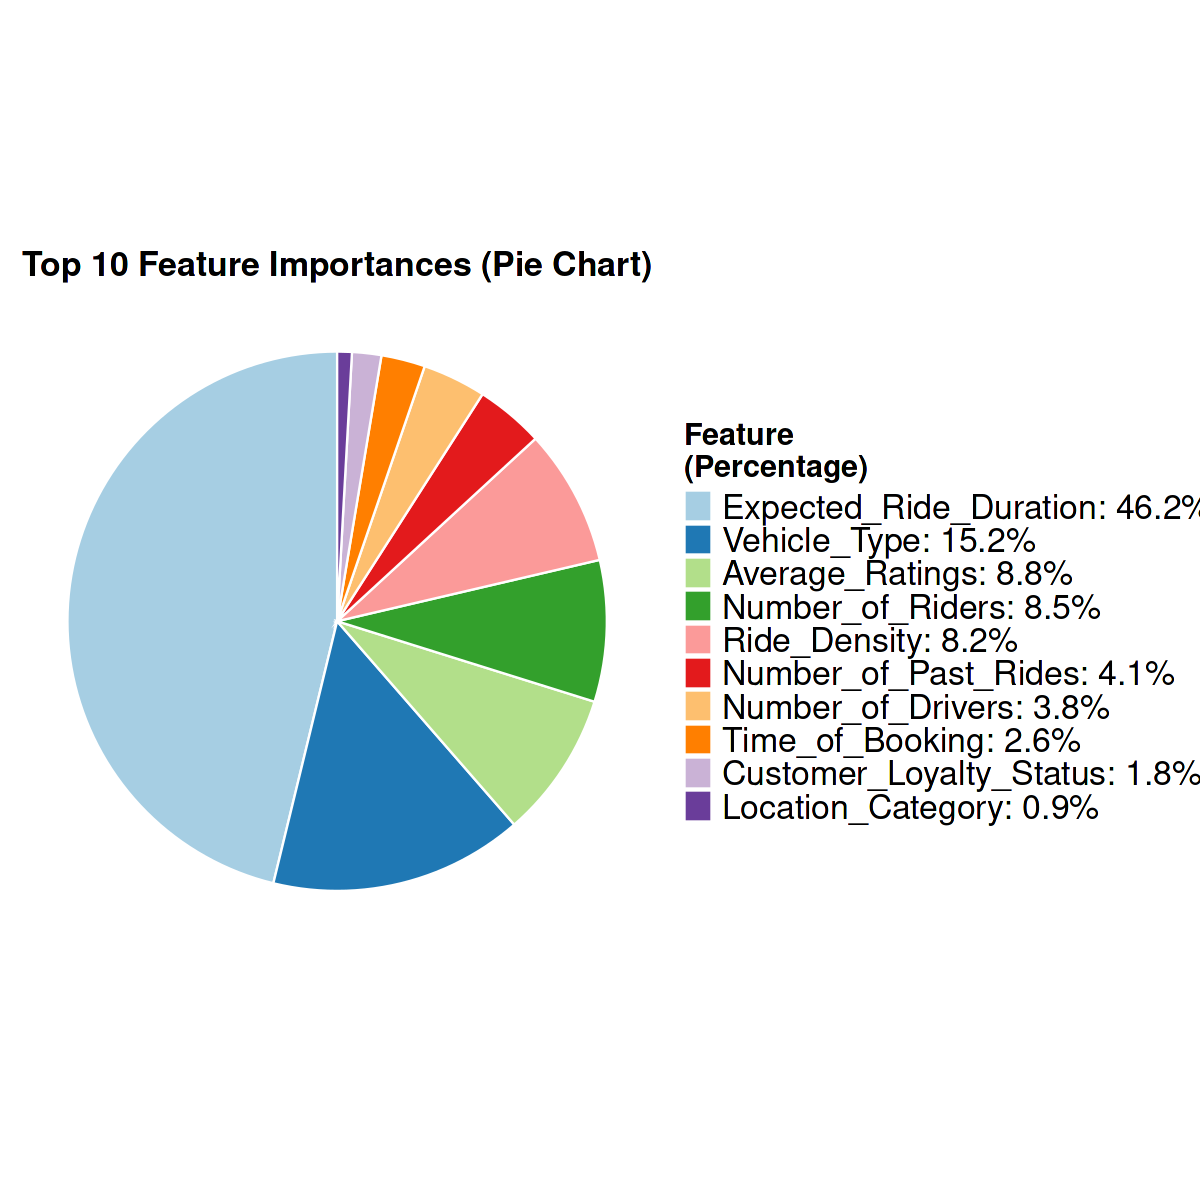

In [26]:
library(scales)

# Prepare the data
importance_df <- as_tibble(importance_matrix) %>%
  slice_max(Frequency, n = 10) %>%
  arrange(desc(Frequency)) %>%
  mutate(
    Feature = factor(Feature, levels = Feature),  # enforce ordering for color mapping
    Percentage = Frequency / sum(Frequency) * 100,
    Label = paste0(Feature, ": ", round(Percentage, 1), "%")
  )

# Plot with correctly mapped legend colors
ggplot(importance_df, aes(x = "", y = Percentage, fill = Feature)) +
  geom_bar(stat = "identity", width = 1, color = "white") +
  coord_polar("y", start = 0) +
  scale_fill_brewer(palette = "Paired", labels = importance_df$Label) +
  theme_void() +
  labs(title = "Top 10 Feature Importances (Pie Chart)", fill = "Feature\n(Percentage)") +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    legend.position = "right",
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 20)
  )


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


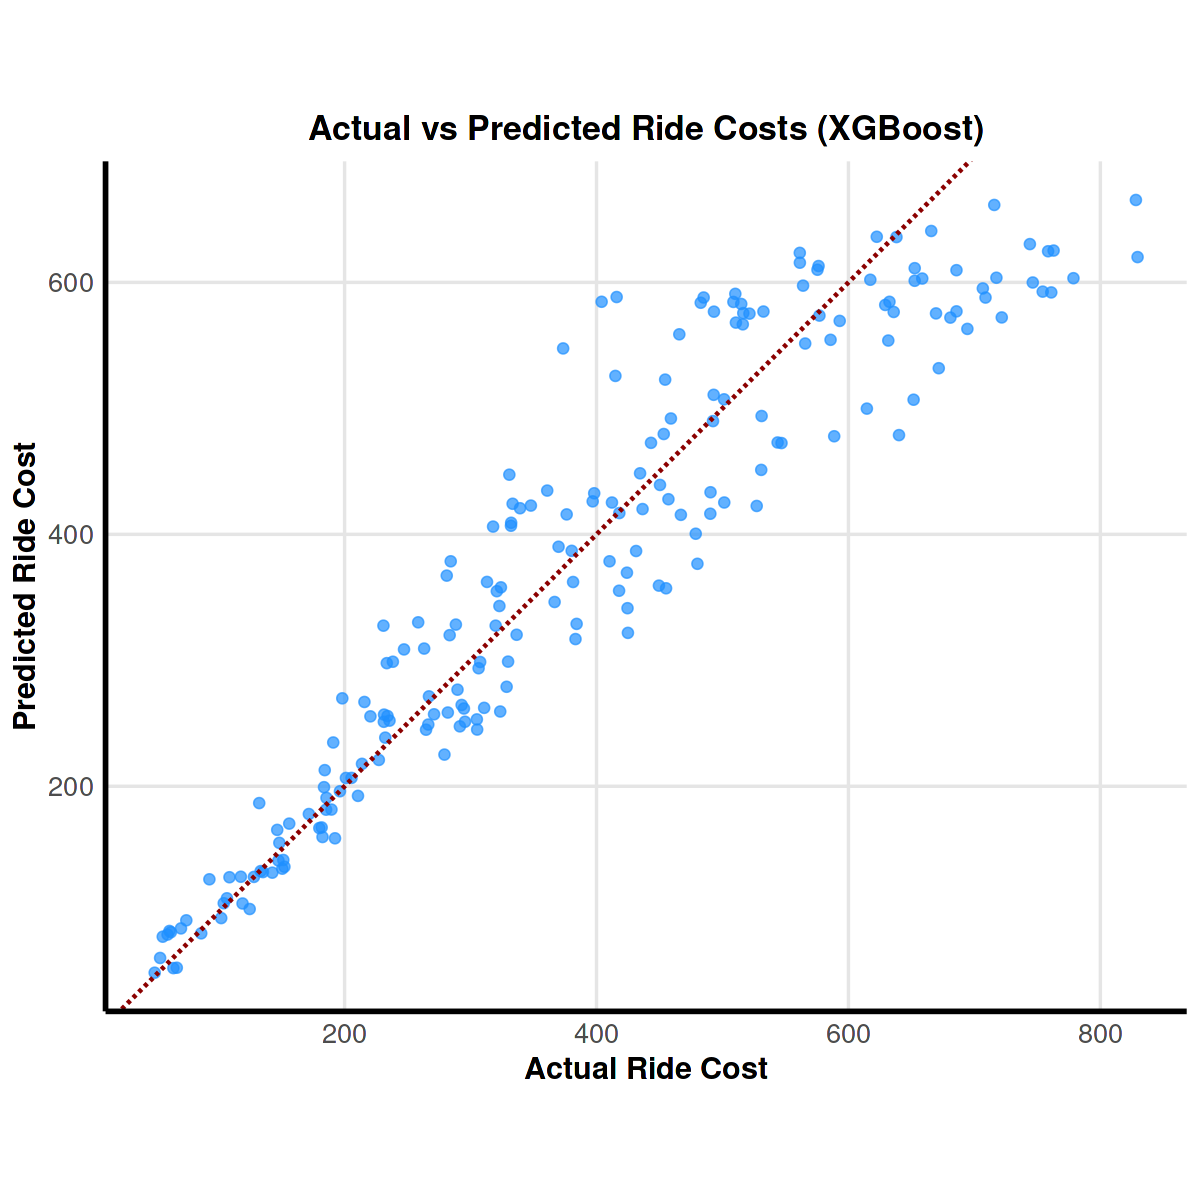

In [27]:
# Actual vs Predicted Plot for XGBoost
library(ggplot2)

# Create a dataframe for plotting
comparison_df <- data.frame(
  Actual = test_data$Historical_Cost_of_Ride,
  Predicted = xgb_preds
)

# Poster-quality Actual vs Predicted Plot
ggplot(comparison_df, aes(x = Actual, y = Predicted)) +
  geom_point(color = "dodgerblue", alpha = 0.7, size = 2.5) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "darkred", size = 1) +
  labs(title = "Actual vs Predicted Ride Costs (XGBoost)",
       x = "Actual Ride Cost",
       y = "Predicted Ride Cost") +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    axis.title.x = element_text(size = 18, face = "bold"),
    axis.title.y = element_text(size = 18, face = "bold"),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    axis.line = element_line(size = 1.2, colour = "black"),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_blank()
  ) +
  coord_equal()

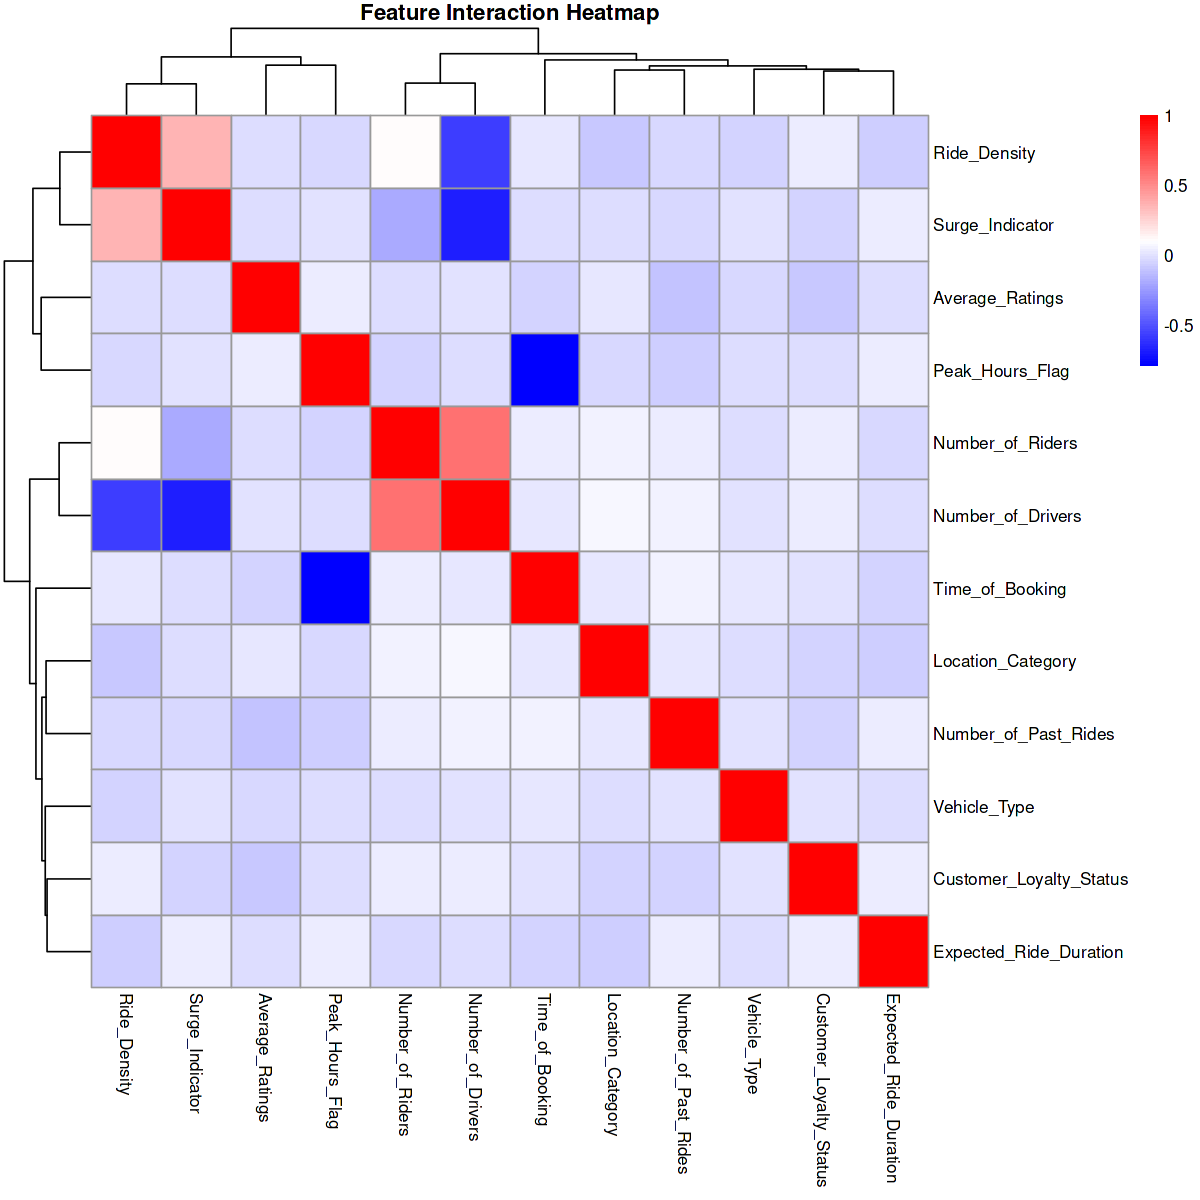

In [31]:
# XGBoost Feature Interaction Heatmap using xgb.importance
xgb_importance <- xgb.importance(feature_names = predictor_columns, model = xgb_model)
library(Matrix)
library(pheatmap)

# Create a correlation matrix of the features
interaction_matrix <- cor(train_data[, predictor_columns], use = "complete.obs")

# Plot the heatmap
pheatmap(interaction_matrix,
         main = "Feature Interaction Heatmap",
         color = colorRampPalette(c("blue", "white", "red"))(100),
         cluster_rows = TRUE, cluster_cols = TRUE)

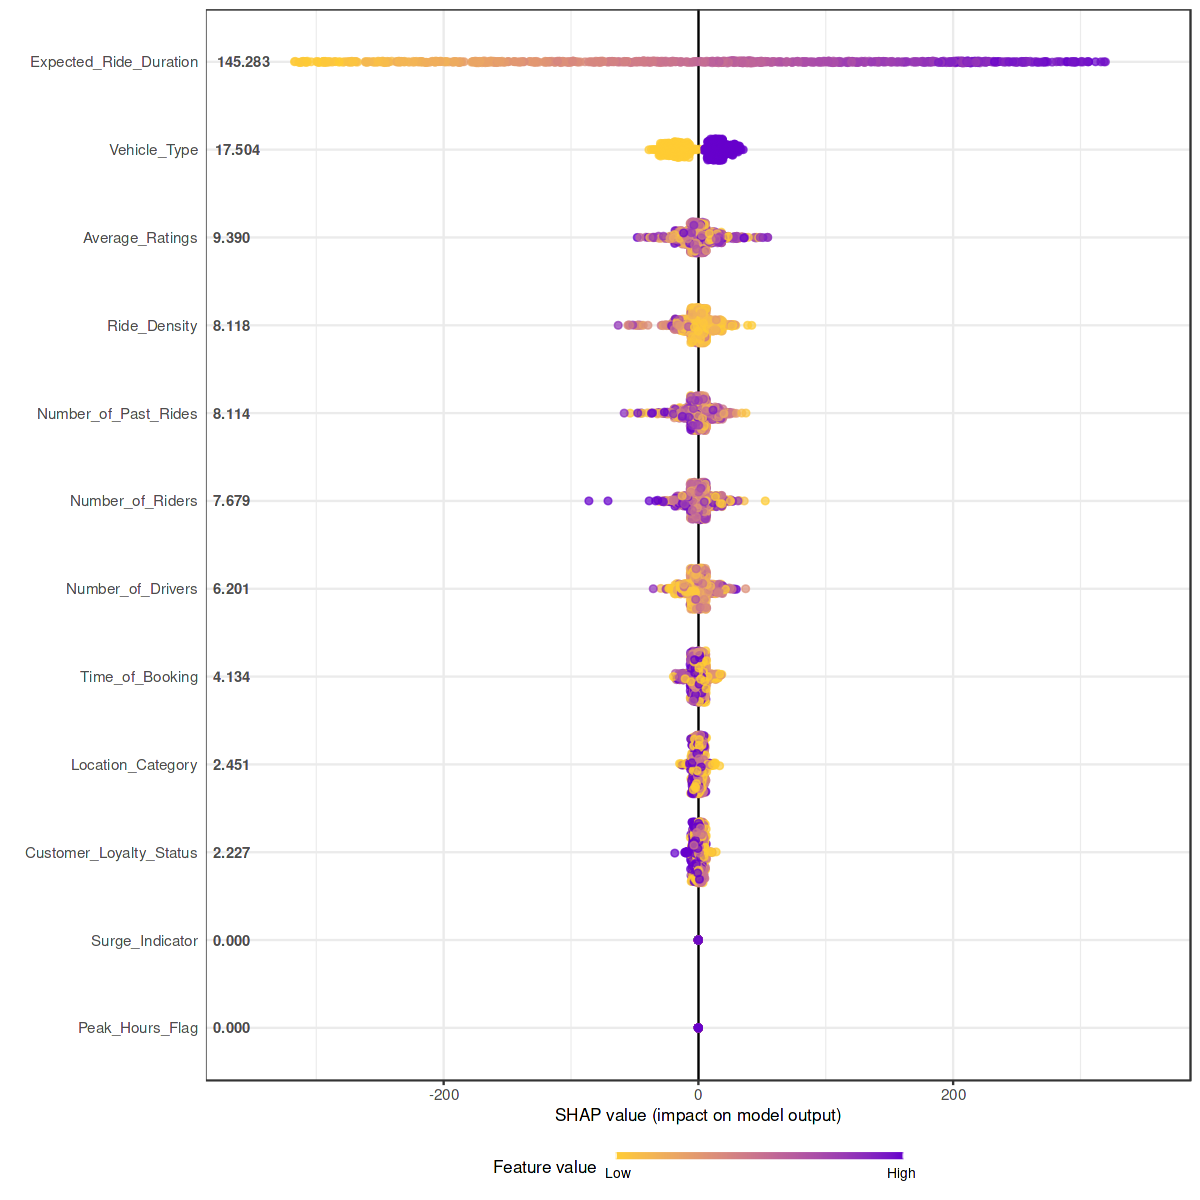

In [34]:
library(SHAPforxgboost)
# Compute SHAP values
shap_values <- shap.values(xgb_model = xgb_model, X_train = as.matrix(train_data[, predictor_columns]))
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train = as.matrix(train_data[, predictor_columns]))

# SHAP Summary Plot
shap.plot.summary(shap_long)